In [3]:
import pandas as pd

In [2]:
# Reload necessary datasets for clustering

customers_path = (r"C:\Users\siddh\OneDrive\Desktop\internship\zeotap\Customers.csv")
transactions_path = (r"C:\Users\siddh\OneDrive\Desktop\internship\zeotap\Transactions.csv")

In [4]:
# Load the datasets
customers = pd.read_csv(r"C:\Users\siddh\OneDrive\Desktop\internship\zeotap\Customers.csv")
transactions = pd.read_csv(r"C:\Users\siddh\OneDrive\Desktop\internship\zeotap\Transactions.csv")

In [5]:
# Merge datasets
customer_transactions = transactions.merge(customers, on="CustomerID", how="left")

Feature Engineering for Clustering

In [6]:
# Calculate total purchase value and transaction frequency for each customer
customer_summary = customer_transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",       # Total purchase value
    "TransactionID": "count"   # Transaction frequency
}).rename(columns={"TotalValue": "TotalPurchaseValue", "TransactionID": "TransactionFrequency"})

# Add customer profile information (Region)
customer_summary = customer_summary.merge(customers[["CustomerID", "Region"]], on="CustomerID", how="left")

# One-hot encode categorical variable (Region)
customer_summary = pd.get_dummies(customer_summary, columns=["Region"], drop_first=True)

# Normalize numeric features for clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_summary.drop("CustomerID", axis=1))


In [7]:
# Perform Clustering with K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Try different cluster sizes (2 to 10) and calculate DB Index
cluster_metrics = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    cluster_metrics.append({"Clusters": n_clusters, "DB_Index": db_index})

# Find the best number of clusters based on the lowest DB Index
best_cluster = min(cluster_metrics, key=lambda x: x["DB_Index"])
optimal_k = best_cluster["Clusters"]

# Run K-Means with optimal number of clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = kmeans_final.fit_predict(scaled_features)
customer_summary["Cluster"] = final_labels

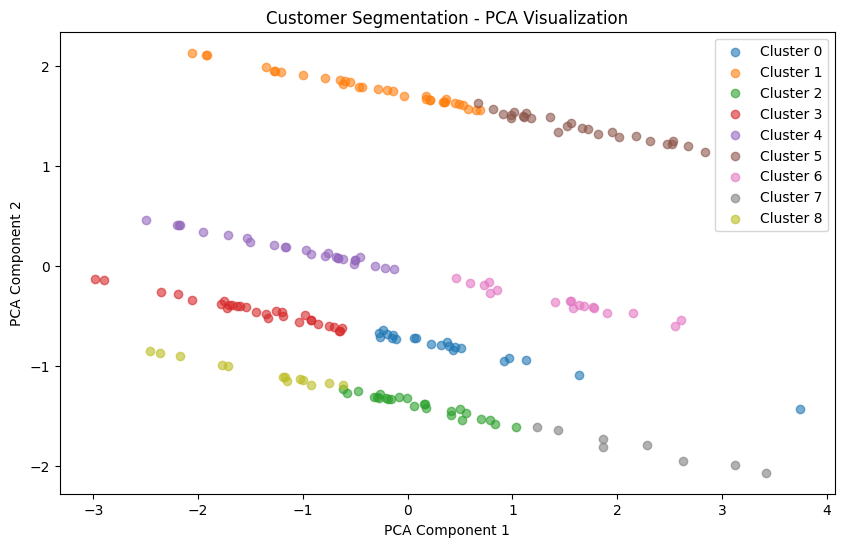

In [8]:
# Visualization of clusters (2D using PCA)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Add PCA components to the dataframe for visualization
customer_summary["PCA1"] = pca_features[:, 0]
customer_summary["PCA2"] = pca_features[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    cluster_data = customer_summary[customer_summary["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f"Cluster {cluster}", alpha=0.6)
plt.title("Customer Segmentation - PCA Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [9]:
# Final cluster metrics and results
best_cluster, customer_summary.head()


({'Clusters': 9, 'DB_Index': np.float64(0.7182543454535527)},
   CustomerID  TotalPurchaseValue  TransactionFrequency  Region_Europe  \
 0      C0001             3354.52                     5          False   
 1      C0002             1862.74                     4          False   
 2      C0003             2725.38                     4          False   
 3      C0004             5354.88                     8          False   
 4      C0005             2034.24                     3          False   
 
    Region_North America  Region_South America  Cluster      PCA1      PCA2  
 0                 False                  True        1  0.348301  1.640892  
 1                 False                 False        4 -0.927502  0.122031  
 2                 False                  True        1 -0.195537  1.755608  
 3                 False                  True        5  2.021774  1.290685  
 4                 False                 False        4 -1.173910  0.193799  )